In [7]:
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
import os
import random
import joblib
import itertools
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations
from catboost import CatBoostClassifier
import seaborn as sns

In [3]:
train = pd.read_pickle("train_addlag.pkl", compression="gzip")
test = pd.read_pickle("test_addlag.pkl", compression="gzip")
features = [col for col in train.columns if col not in ['customer_ID','target']]
print(len(features))#1365 features
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]

1365


In [4]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [5]:
class AmexCatboostMetric(object):
    def get_final_error(self, error, weight): return error
    def is_max_optimal(self): return True
    def evaluate(self, approxes, target, weight): return amex_metric(np.array(target), approxes[0]), 1.0

 
--------------------------------------------------
Training fold 0 with 1365 features...
0:	learn: 0.6960008	test: 0.6996322	best: 0.6996322 (0)	total: 903ms	remaining: 5h 8m 27s
100:	learn: 0.7757689	test: 0.7776321	best: 0.7776485 (98)	total: 1m 43s	remaining: 5h 48m 47s
200:	learn: 0.7867188	test: 0.7871732	best: 0.7871732 (200)	total: 3m 21s	remaining: 5h 39m 4s
300:	learn: 0.7938151	test: 0.7910547	best: 0.7910673 (296)	total: 5m	remaining: 5h 36m 22s
400:	learn: 0.7993003	test: 0.7924947	best: 0.7925228 (389)	total: 6m 40s	remaining: 5h 34m 57s
500:	learn: 0.8041592	test: 0.7941662	best: 0.7944537 (487)	total: 8m 22s	remaining: 5h 34m 6s
600:	learn: 0.8083762	test: 0.7953597	best: 0.7955238 (598)	total: 10m 1s	remaining: 5h 32m 9s
700:	learn: 0.8113736	test: 0.7958850	best: 0.7961689 (649)	total: 11m 37s	remaining: 5h 28m 28s
800:	learn: 0.8140127	test: 0.7965565	best: 0.7968061 (797)	total: 13m 12s	remaining: 5h 24m 46s
900:	learn: 0.8169108	test: 0.7972861	best: 0.7973190 (89

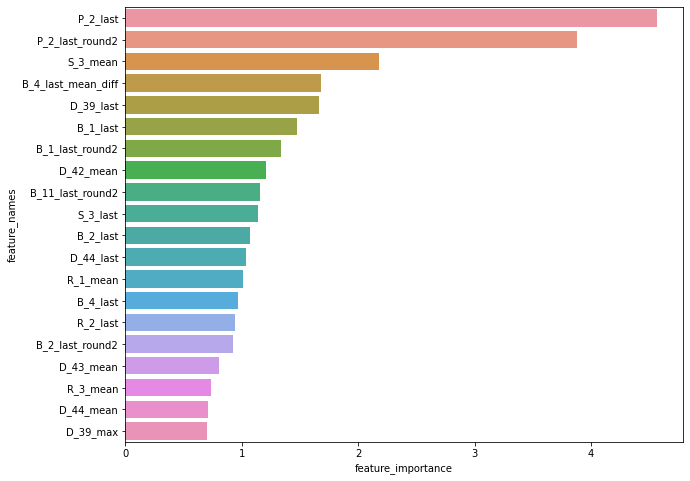

None
Our fold 0 CV score is 0.8004830388293414
 
--------------------------------------------------
Training fold 1 with 1365 features...
0:	learn: 0.6967950	test: 0.6962284	best: 0.6962284 (0)	total: 680ms	remaining: 3h 52m 10s
100:	learn: 0.7771611	test: 0.7713080	best: 0.7713080 (100)	total: 1m 40s	remaining: 5h 38m 57s
200:	learn: 0.7884211	test: 0.7803016	best: 0.7803016 (200)	total: 3m 19s	remaining: 5h 35m 59s
300:	learn: 0.7955607	test: 0.7856323	best: 0.7856323 (300)	total: 4m 57s	remaining: 5h 32m 54s
400:	learn: 0.8007416	test: 0.7863597	best: 0.7866460 (372)	total: 6m 33s	remaining: 5h 29m 1s
500:	learn: 0.8050416	test: 0.7872491	best: 0.7872491 (500)	total: 8m 11s	remaining: 5h 26m 47s
600:	learn: 0.8093239	test: 0.7883877	best: 0.7884491 (590)	total: 9m 47s	remaining: 5h 24m 24s
700:	learn: 0.8133286	test: 0.7881461	best: 0.7885031 (634)	total: 11m 23s	remaining: 5h 21m 50s
800:	learn: 0.8167694	test: 0.7886051	best: 0.7888270 (755)	total: 12m 59s	remaining: 5h 19m 21s
90

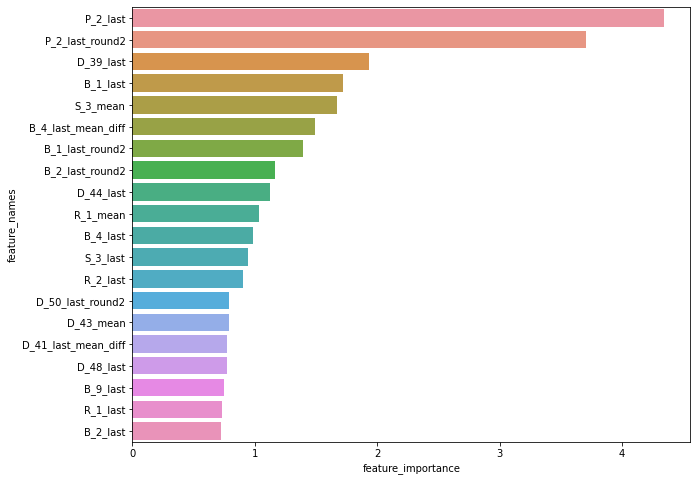

None
Our fold 1 CV score is 0.7921758435823043
 
--------------------------------------------------
Training fold 2 with 1365 features...
0:	learn: 0.7011114	test: 0.6990666	best: 0.6990666 (0)	total: 1.55s	remaining: 8h 50m 8s
100:	learn: 0.7773875	test: 0.7743462	best: 0.7743462 (100)	total: 2m 25s	remaining: 8h 9m 36s
200:	learn: 0.7883361	test: 0.7817637	best: 0.7817945 (197)	total: 4m 47s	remaining: 8h 4m 21s
300:	learn: 0.7950009	test: 0.7874922	best: 0.7875275 (299)	total: 7m 9s	remaining: 8h 54s
400:	learn: 0.8000626	test: 0.7890923	best: 0.7890923 (400)	total: 9m 32s	remaining: 7h 57m 59s
500:	learn: 0.8041794	test: 0.7907625	best: 0.7914182 (480)	total: 11m 53s	remaining: 7h 54m 38s
600:	learn: 0.8080368	test: 0.7918993	best: 0.7921247 (589)	total: 14m 15s	remaining: 7h 52m 20s
700:	learn: 0.8112444	test: 0.7928076	best: 0.7930018 (688)	total: 16m 33s	remaining: 7h 47m 45s
800:	learn: 0.8146923	test: 0.7929954	best: 0.7934372 (784)	total: 18m 53s	remaining: 7h 44m 29s
900:	le

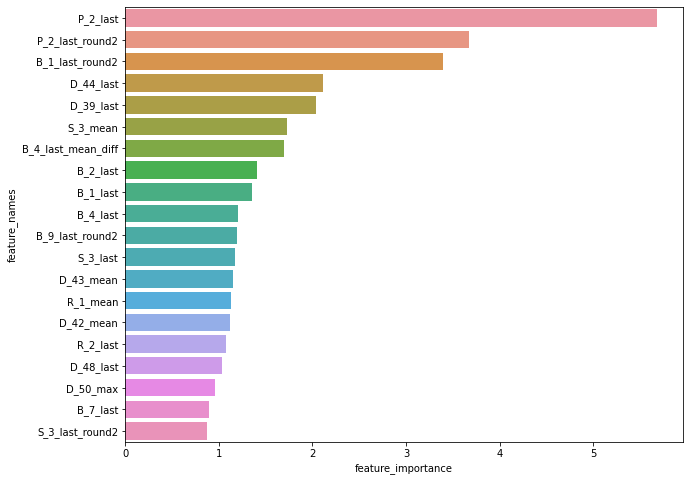

None
Our fold 2 CV score is 0.7960927112161625
 
--------------------------------------------------
Training fold 3 with 1365 features...
0:	learn: 0.7001650	test: 0.6941004	best: 0.6941004 (0)	total: 1.4s	remaining: 7h 59m 33s
100:	learn: 0.7780394	test: 0.7700263	best: 0.7704447 (98)	total: 2m 28s	remaining: 8h 18m 17s
200:	learn: 0.7889612	test: 0.7776374	best: 0.7778148 (199)	total: 4m 56s	remaining: 8h 19m 33s
300:	learn: 0.7960545	test: 0.7818193	best: 0.7820233 (299)	total: 7m 22s	remaining: 8h 15m 17s
400:	learn: 0.8008990	test: 0.7844347	best: 0.7844925 (395)	total: 9m 49s	remaining: 8h 12m 16s
500:	learn: 0.8055620	test: 0.7856339	best: 0.7858568 (496)	total: 12m 15s	remaining: 8h 9m 13s
600:	learn: 0.8094963	test: 0.7866823	best: 0.7866823 (600)	total: 14m 40s	remaining: 8h 6m 8s
700:	learn: 0.8128179	test: 0.7867202	best: 0.7869703 (626)	total: 17m 2s	remaining: 8h 1m 5s
800:	learn: 0.8159798	test: 0.7873526	best: 0.7874307 (793)	total: 19m 23s	remaining: 7h 56m 46s
900:	le

8100:	learn: 0.9076703	test: 0.7936543	best: 0.7939847 (7967)	total: 3h 2m 52s	remaining: 4h 39m 54s
8200:	learn: 0.9086428	test: 0.7937003	best: 0.7939847 (7967)	total: 3h 5m 9s	remaining: 4h 37m 41s
8300:	learn: 0.9098787	test: 0.7934280	best: 0.7939847 (7967)	total: 3h 7m 26s	remaining: 4h 35m 28s
8400:	learn: 0.9110827	test: 0.7934895	best: 0.7939847 (7967)	total: 3h 9m 43s	remaining: 4h 33m 14s
8500:	learn: 0.9120710	test: 0.7936618	best: 0.7939847 (7967)	total: 3h 11m 57s	remaining: 4h 30m 56s
8600:	learn: 0.9132089	test: 0.7940237	best: 0.7941682 (8581)	total: 3h 14m 14s	remaining: 4h 28m 43s
8700:	learn: 0.9142162	test: 0.7937340	best: 0.7941682 (8581)	total: 3h 16m 27s	remaining: 4h 26m 24s
8800:	learn: 0.9151687	test: 0.7940310	best: 0.7941984 (8795)	total: 3h 18m 42s	remaining: 4h 24m 8s
8900:	learn: 0.9164193	test: 0.7942499	best: 0.7942691 (8896)	total: 3h 21m	remaining: 4h 21m 56s
9000:	learn: 0.9178158	test: 0.7937170	best: 0.7944828 (8902)	total: 3h 23m 21s	remaining: 4

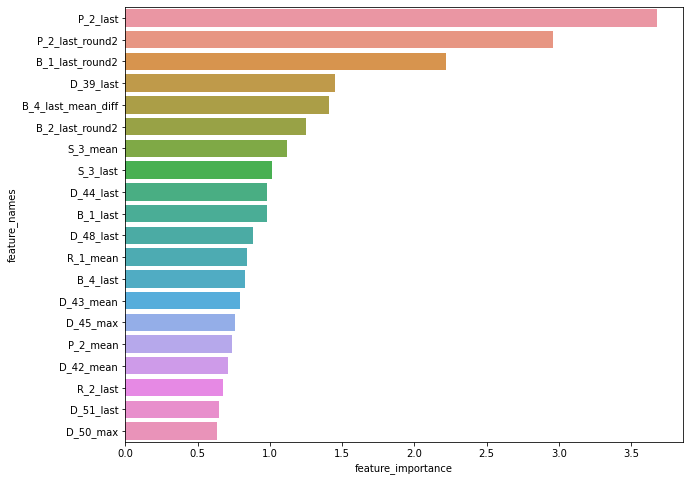

None
Our fold 3 CV score is 0.7944827683996192
 
--------------------------------------------------
Training fold 4 with 1365 features...
0:	learn: 0.7075892	test: 0.7081572	best: 0.7081572 (0)	total: 1.98s	remaining: 11h 15m 40s
100:	learn: 0.7765179	test: 0.7736163	best: 0.7736163 (100)	total: 2m 24s	remaining: 8h 7m 12s
200:	learn: 0.7878428	test: 0.7809560	best: 0.7809560 (200)	total: 4m 48s	remaining: 8h 5m 50s
300:	learn: 0.7948169	test: 0.7858924	best: 0.7858924 (300)	total: 7m 11s	remaining: 8h 2m 45s
400:	learn: 0.7998507	test: 0.7880789	best: 0.7883975 (397)	total: 9m 34s	remaining: 8h 5s
500:	learn: 0.8038602	test: 0.7890482	best: 0.7891735 (488)	total: 11m 55s	remaining: 7h 55m 59s
600:	learn: 0.8081279	test: 0.7905545	best: 0.7905545 (600)	total: 14m 18s	remaining: 7h 53m 52s
700:	learn: 0.8119559	test: 0.7914116	best: 0.7914116 (700)	total: 16m 42s	remaining: 7h 51m 53s
800:	learn: 0.8155956	test: 0.7919520	best: 0.7922471 (799)	total: 19m 5s	remaining: 7h 49m 24s
900:	le

8100:	learn: 0.9150617	test: 0.7968678	best: 0.7973543 (7667)	total: 3h 10m 12s	remaining: 4h 51m 7s
8200:	learn: 0.9160699	test: 0.7967039	best: 0.7973543 (7667)	total: 3h 12m 32s	remaining: 4h 48m 45s
8300:	learn: 0.9173619	test: 0.7968060	best: 0.7973543 (7667)	total: 3h 14m 55s	remaining: 4h 46m 27s
8400:	learn: 0.9185659	test: 0.7967206	best: 0.7973543 (7667)	total: 3h 17m 25s	remaining: 4h 44m 20s
8500:	learn: 0.9192377	test: 0.7969482	best: 0.7973543 (7667)	total: 3h 19m 43s	remaining: 4h 41m 54s
8600:	learn: 0.9203223	test: 0.7966793	best: 0.7973543 (7667)	total: 3h 22m 2s	remaining: 4h 39m 30s
8700:	learn: 0.9213755	test: 0.7967439	best: 0.7973543 (7667)	total: 3h 24m 19s	remaining: 4h 37m 4s
8800:	learn: 0.9221413	test: 0.7967434	best: 0.7973543 (7667)	total: 3h 26m 35s	remaining: 4h 34m 37s
8900:	learn: 0.9227417	test: 0.7969130	best: 0.7973543 (7667)	total: 3h 28m 50s	remaining: 4h 32m 8s
9000:	learn: 0.9236789	test: 0.7970148	best: 0.7973543 (7667)	total: 3h 31m 40s	remain

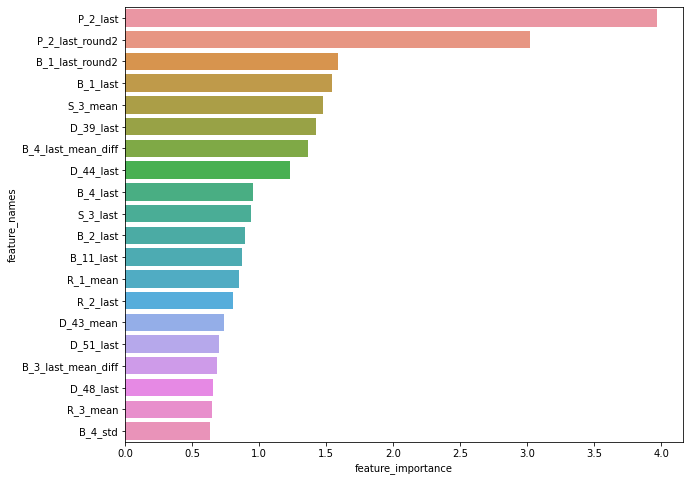

None
Our fold 4 CV score is 0.7973542691642761
Our out of folds CV score is 0.7953268086522072


In [8]:
features = [col for col in train.columns if col not in ['customer_ID', 'target']]
# Create a numpy array to store test predictions
test_predictions = np.zeros(len(test))
# Create a numpy array to store out of folds predictions
oof_predictions = np.zeros(len(train))
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state =42)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train['target'])):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {len(features)} features...')
    x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
    y_train, y_val = train['target'].iloc[trn_ind], train['target'].iloc[val_ind]

    param= {
            'objective': 'Logloss',
            "loss_function": "Logloss",
            'depth': 8,
            'l2_leaf_reg': 70,
            'od_type': 'Iter',
            'random_seed': 42,
            'colsample_bylevel':0.7908035831805076,
            'iterations': 20500,
            'early_stopping_rounds': 1500,
            'random_strength':0.4737370648739252,
            'bagging_temperature':0.5946334626621413
            }

    bst = CatBoostClassifier(**param,eval_metric = AmexCatboostMetric())
    model = bst.fit(x_train, y_train, eval_set=[(x_val, y_val)], cat_features=cat_features, verbose=100)

    # Save best model
    joblib.dump(model, f'catboost_fold{fold}_addlag_tune.pkl')
    
    feature_importance = np.array(model.get_feature_importance())
    feature_names = np.array(features)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.iloc[:20,:]
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    print(plt.show())
    
    # Predict validation
    val_pred = model.predict_proba(x_val)[:, 1]

    # Add to out of folds array
    oof_predictions[val_ind] = val_pred
    # Predict the test set
    test_pred = model.predict_proba(test[features])[:, 1]

    test_predictions += test_pred / 5
    # Compute fold metric
    score = amex_metric(y_val, val_pred)
    print(f'Our fold {fold} CV score is {score}')
    del x_train, x_val, y_train, y_val
    gc.collect()
# Compute out of folds metric
score = amex_metric(train['target'], oof_predictions)
print(f'Our out of folds CV score is {score}')

In [9]:
oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train['target'], 'prediction': oof_predictions})
oof_df.to_csv('oof_catboost_tune_seed42.csv', index = False)
# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
test_df.to_csv('test_catboost_tune_seed42.csv', index = False) #0.795